In [1]:
import numpy as np 
import pandas as pd 
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import random 

In [2]:
from src.base_model import base_model 
from src.trial_error_model import trial_error_model
from src.demand_generator import demand_generator 
from src.network import generate_neighboring_candid
from src.network import generate_modified_od 

In [3]:
# loading the travel time data

od = pd.read_csv('data/od.csv').set_index('Unnamed: 0')
od.index.name = 'zone'
od.columns = od.columns.astype(np.int32)
od.index = od.index.astype(np.int32)

od = od.iloc[:693,:693]
od = od/60

od_dict = {}
for i in od.index:
    for j in od.columns:
        od_dict[i,j]= od.loc[i,j]

In [4]:
# loading the population data (thousand people)

data = pd.read_csv('data/pop.csv')
data['pop'] = data['pop']/10**3
data = data[['zone','pop']] 

In [5]:
# Loading the list of candidate location 

candid = pd.read_csv('data/candid.csv')
candid = candid[candid['Station']==1].zone.tolist()
len(candid)

125

### Demand

In [6]:
# Generating the demand 

random.seed(1)

scenario_num = 15 #number of scenarios 
initial_num_hit = 10 
vicinity_threshold = 8.5 # minutes 
percentage_affected = 0.3

demand = demand_generator(data,
                     od,
                     scenario_num,
                     initial_num_hit,
                     vicinity_threshold,
                     percentage_affected)

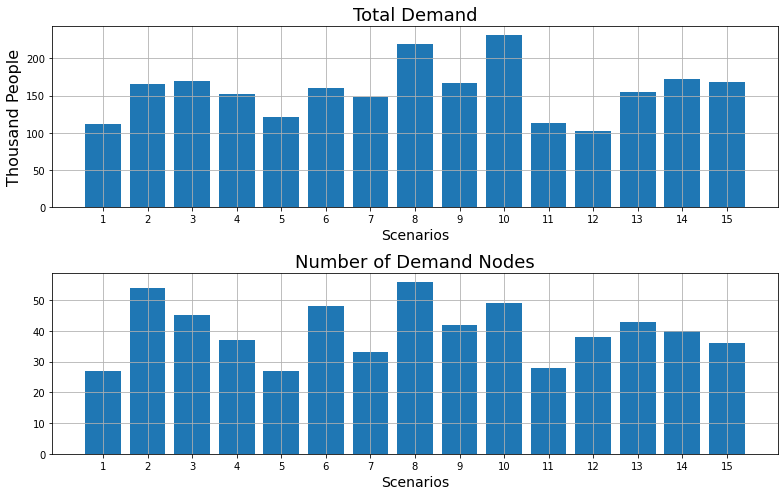

In [7]:
# Visualizing the demand data 

all_dem = {i:0 for i in demand.keys()}
for i in demand.keys():
    for j in demand[i].keys():
        all_dem[i] += demand[i][j]
node_num = {i:len(demand[i].keys()) for i in demand.keys()}

demand_vis = pd.DataFrame({'total':all_dem, 'node_number':node_num})

fig, axs = plt.subplots(figsize=(11,7), nrows=2, ncols=1)
for ax, kind, label, ylab in zip(axs.flat, demand_vis.columns, ['Total Demand', 'Number of Demand Nodes'], ['Thousand People','']):
    ax.bar(x=demand_vis.index.tolist(), height=demand_vis[kind])
    ax.set_title(f'{label}',  fontsize=18)
    ax.set_xlabel('Scenarios', fontsize=14)
    ax.set_ylabel(f'{ylab}', fontsize=16)
    ax.grid()
    ax.set_xticks(demand_vis.index.tolist())

plt.tight_layout()    
plt.show()

### Sorted Neighboring Candidate (${N_i}$)

In [8]:
set_length = 10 

nearest_candid = generate_neighboring_candid(demand, candid, od, set_length)

### Recalculated Travel Time (${T'_{i,j}}$)

In [9]:
modified_od = generate_modified_od(demand=demand, candid=candid, nearest_candid=nearest_candid, od=od_dict)

## Single Run 

### Base Model

In [10]:
scenario = 2
max_shelter_num = 50
shelter_cap = 2
gamma = 120


m_base = base_model(scenario=scenario, demand=demand, od=od_dict, candidate=candid,
                  max_shelter_num=max_shelter_num, shelter_cap=shelter_cap,
                  gamma=gamma)

In [11]:
solver = pyo.SolverFactory('cbc')

res = solver.solve(m_base)

print(res)
print('------------------------------------------')
print('Obejctive Function Value:')
pyo.value(m_base.objective)


Problem: 
- Name: unknown
  Lower bound: 55.71370125
  Upper bound: 55.71370125
  Number of objectives: 1
  Number of constraints: 172
  Number of variables: 6489
  Number of binary variables: 125
  Number of integer variables: 125
  Number of nonzeros: 6372
  Sense: minimize
Solver: 
- Status: ok
  User time: -1.0
  System time: 1.98
  Wallclock time: 2.36
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 48
      Number of created subproblems: 48
    Black box: 
      Number of iterations: 1027
  Error rc: 0
  Time: 2.488722324371338
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

------------------------------------------
Obejctive Function Value:


55.713701259292584

### Trial-and-Error Model 

In [12]:
scenario = 2
max_shelter_num = 50
shelter_cap = 2
gamma = 120


m_trial = trial_error_model(scenario=scenario, demand=demand, od=modified_od, candidate=candid, nearest_candid=nearest_candid,
                      max_shelter_num=max_shelter_num, shelter_cap=shelter_cap,
                      gamma=gamma)

In [13]:
solver = pyo.SolverFactory('cbc')

res = solver.solve(m_trial)

print(res)
print('------------------------------------------')
print('Obejctive Function Value:')
pyo.value(m_trial.objective)


Problem: 
- Name: unknown
  Lower bound: 73.04733725
  Upper bound: 73.04733725
  Number of objectives: 1
  Number of constraints: 172
  Number of variables: 6489
  Number of binary variables: 125
  Number of integer variables: 125
  Number of nonzeros: 6372
  Sense: minimize
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.08
  Wallclock time: 0.27
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
    Black box: 
      Number of iterations: 0
  Error rc: 0
  Time: 0.41849350929260254
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

------------------------------------------
Obejctive Function Value:


73.0473372467303

## Multiple Runs

In [14]:
models = {'trial':[], 'base':[]}

for rep in demand.keys():
    
    model_v1 = base_model(scenario=rep, demand=demand, od=od_dict, candidate=candid,
                          max_shelter_num=max_shelter_num, shelter_cap=shelter_cap,
                          gamma=gamma)
    models['base'].append(model_v1)
    
    model_v2 = trial_error_model(scenario=rep, demand=demand, od=modified_od, candidate=candid, nearest_candid=nearest_candid,
                                 max_shelter_num=max_shelter_num, shelter_cap=shelter_cap,
                                 gamma=gamma)
    models['trial'].append(model_v2)

In [15]:
result_models = {'trial':[], 'base':[]}

for m in range(len(models['trial'])):
    model_t = models['trial'][m]
    model_b = models['base'][m]
    res_t = solver.solve(model_t)
    res_b = solver.solve(model_b)
    result_models['trial'].append(pyo.value(model_t.objective))
    result_models['base'].append(pyo.value(model_b.objective))

## Comapring the Results

### 1. Evacuees' Average Time to Find Shelters 

In [16]:
time_avg = pd.DataFrame.from_dict(result_models)
time_avg.columns = ['Trial-Error Model', 'Base Model']
time_avg.index = pd.Index(list(demand.keys()))

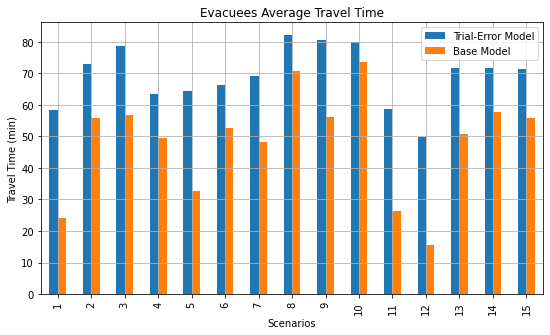

In [17]:
time_avg.plot(kind='bar', title='Evacuees Average Travel Time', 
              legend = ['Trial-Error Model', 'Base Model'],
              xlabel='Scenarios', ylabel='Travel Time (min)',
              grid=True, figsize=[9,5])

plt.show()

### 2. Number of Identical Stations Found

In [18]:
identical_stations = {k:None for k in range(len(models['trial']))}

for sec in models.keys():
    for k in range(len(models['trial'])):
        model_t = models['trial'][k]
        model_b = models['base'][k]
        
        model_t_stations=[]
        model_b_stations=[]
        
        for j in model_t.J:
            if pyo.value(model_t.x[j]) == 1:
                model_t_stations.append(j)
                
        for j in model_b.J:
            if pyo.value(model_b.x[j]) == 1:
                model_b_stations.append(j)
                
        
        model_t_stations = np.array(model_t_stations)
        model_b_stations = np.array(model_b_stations)
        
        identical_stations[k] = len(np.intersect1d(model_t_stations, model_b_stations))/model_t.max_located

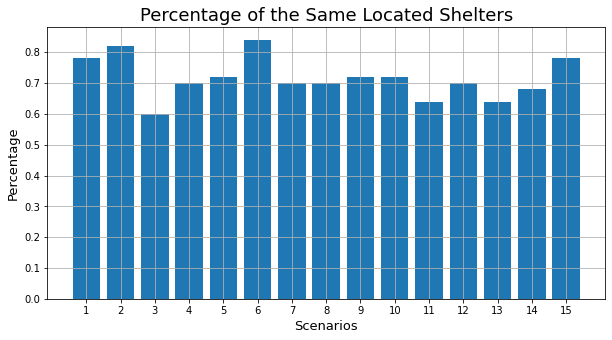

In [19]:
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(x=list(demand.keys()), height = identical_stations.values())
ax.set_ylabel('Percentage', fontsize=13)
ax.set_xlabel('Scenarios', fontsize=13)
ax.set_title('Percentage of the Same Located Shelters', fontsize=18) 
ax.grid()
ax.set_xticks(list(demand.keys()))
plt.show()

###

### 3. Percentage of evacuees going to same shelters 

In [20]:
evacuess_same_shelters = {k:0 for k in range(len(models['trial']))}

for sec in models.keys():
    for k in range(len(models['trial'])):
        model_t = models['trial'][k]
        model_b = models['base'][k]
        
        for i in model_t.I:
            for j in model_t.J:
                
                ppl_t = pyo.value(model_t.y[i,j])
                ppl_b = pyo.value(model_b.y[i,j])
                
                evacuess_same_shelters[k] += min(ppl_t, ppl_b)/model_t.all_demand

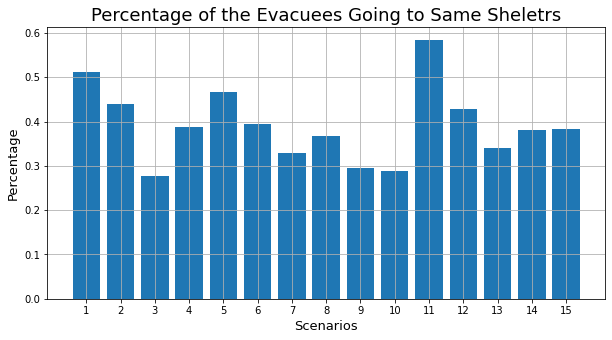

In [21]:
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(x=list(demand.keys()), height = evacuess_same_shelters.values())
ax.set_ylabel('Percentage',  fontsize=13)
ax.set_xlabel('Scenarios',  fontsize=13)
ax.set_title('Percentage of the Evacuees Going to Same Sheletrs', fontsize=18) 
ax.grid()
ax.set_xticks(list(demand.keys()))

plt.show()